In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

In [2]:
xr.set_options(display_style='text')

In [3]:
path = 'pangeo-tmp/stb2145/GODAS/datasets/'
ds = xr.open_zarr(gcsfs.GCSMap(path + 'ds_wg.zarr'))
coords = xr.open_zarr(gcsfs.GCSMap(path + 'coords_wg.zarr'))
cell_coords = xr.open_zarr(gcsfs.GCSMap(path + 'cell_coords_wg.zarr'))
cell_elements = xr.open_zarr(gcsfs.GCSMap(path + 'cell_elements_wg.zarr'))
surf_flux = xr.open_zarr(gcsfs.GCSMap(path + 'surf_flux.zarr'))
total_tend = xr.open_zarr(gcsfs.GCSMap(path + 'total_tend.zarr'))
tendency = xr.open_zarr(gcsfs.GCSMap(path + 'tendency.zarr'))
vel = xr.open_zarr(gcsfs.GCSMap(path + 'vel.zarr'))

In [5]:
#slicing datasets to finish Feb 1, 2019 so that time will line up at dVdt section 
ds = ds.isel(time=slice(0, -1))
surf_flux = surf_flux.isel(time=slice(0,-1))

In [6]:
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'lon', 'right': 'lon_u'}, 
                             'Y': {'center': 'lat', 'right': 'lat_u'},
                             'T': {'center': 'time'},
                             'Z': {'center': 'level', 'right': 'level_w'}},
                     periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> right
  * right    lon_u --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> right
  * right    lat_u --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   level --> right
  * right    level_w --> center

In [15]:
mask_ucur = ds.ucur != ds.ucur.isnull()
mask_vcur = ds.vcur != ds.vcur.isnull()

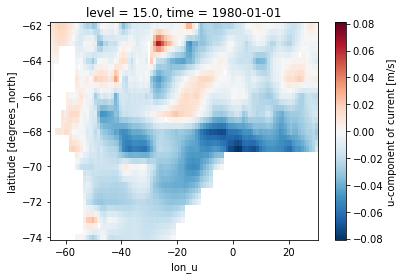

In [17]:
ds.ucur.where(mask_ucur)[0,1].plot()

In [21]:
ds.ucur.isel(level=slice(20, -1))

<xarray.DataArray 'ucur' (time: 470, level: 19, lat_u: 37, lon_u: 96)>
dask.array<getitem, shape=(470, 19, 37, 96), dtype=float32, chunksize=(4, 19, 37, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * level    (level) float32 205.0 215.0 225.0 ... 3.016e+03 3.483e+03 3.972e+03
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
Attributes:
    center:                   US National Weather Service - NCEP (WMC)
    dataset:                  NCEP GODAS
    gds_grid_type:            0
    level_desc:               Multiple Levels
    level_indicator:          160
    long_name:                u-component of current
    parameter_number:         49
    parameter_table_version:  2
    parent_stat:              Individual Obs
    statistic:                Monthly Mean
    sub_center:               Environmental Modeling Center
    units:                    m/s
    unpacked_valid_range:     [-2.0, 2.0]
    valid_range:              [-16384, 16384]
    var_desc:                 u of current

In [26]:
u_transport_right = (ds.ucur * cell_elements.dy * cell_elements.dz).isel(lon_u=-1, level=slice(25, -1))
u_transport_left = (ds.ucur * cell_elements.dy * cell_elements.dz).isel(lon_u=0, level=slice(25, -1))

v_transport = (ds.vcur * cell_elements.dx_interp * cell_elements.dz).isel(lat_u=-1, level=slice(25, -1))
#units: m^3/s

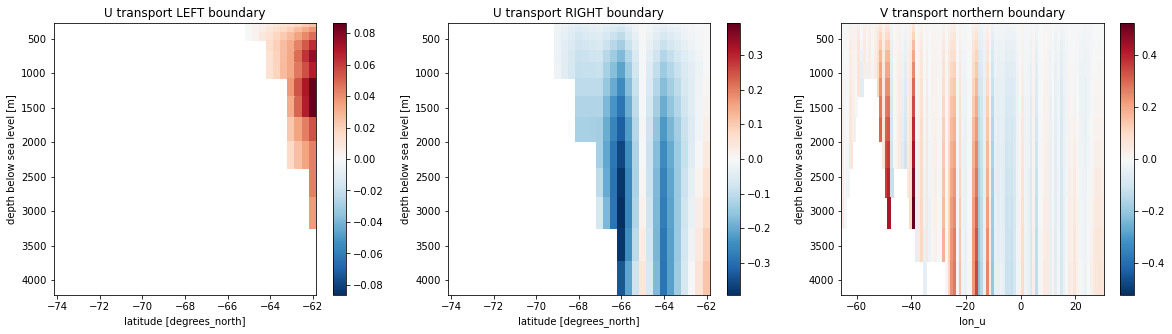

In [27]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [28]:
# BEST WAY TO DO IT
u_transport_mean_value = (u_transport_right.fillna(0.).sum(dim=['lat_u', 'level']) -
                          u_transport_left.fillna(0.).sum(dim=['lat_u', 'level'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-41.928734, dtype=float32)

In [29]:
v_transport_mean_value = (v_transport).fillna(0.).sum(dim=['lon_u', 'level']).mean(dim='time')/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(19.960785, dtype=float32)
Coordinates:
    lat_u    float32 -62.0